In [3]:
import pandas as pd

In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Epoch 1/5
31/31 [==============================] - 10s 117ms/step - loss: 0.0407 - val_loss: 0.0046
Epoch 2/5
31/31 [==============================] - 2s 79ms/step - loss: 0.0075 - val_loss: 0.0063
Epoch 3/5
31/31 [==============================] - 2s 78ms/step - loss: 0.0058 - val_loss: 0.0044
Epoch 4/5
31/31 [==============================] - 2s 79ms/step - loss: 0.0057 - val_loss: 0.0044
Epoch 5/5
8/8 [==============================] - 1s 25ms/step


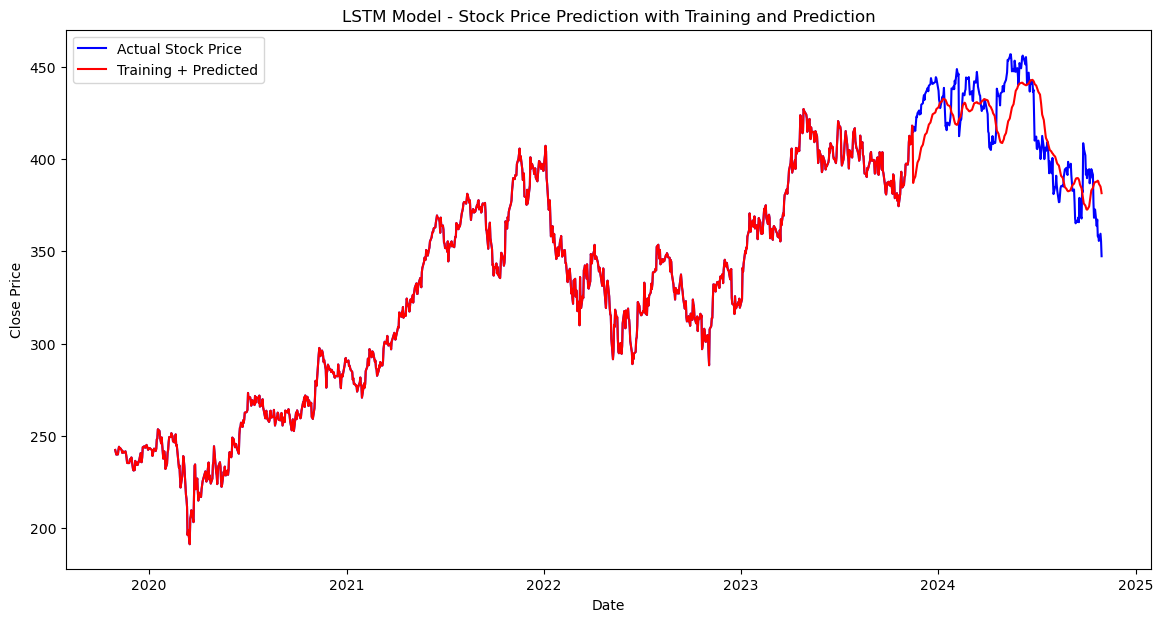

In [51]:

df = pd.read_csv('../Data/loreal_stock_price.csv', parse_dates=['Date'], index_col='Date')
# Assuming 'df' is your DataFrame and 'Close' is the column with daily closing prices
# Convert to numpy array for scaling and reshape
data = df[['Close']].values

# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define a function to create sequences for LSTM
def create_sequences(data, seq_length, lag=0):
    X, y = [], []
    for i in range(len(data) - seq_length - lag + 1):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length + lag - 1, 0])
        
    return np.array(X), np.array(y)

# Define sequence length and prepare the dataset
sequence_length = 60  # This means each input sequence will be 60 days of past data
lag = 7  # This is the number of days to predict into the future
X, y = create_sequences(scaled_data, sequence_length, lag)

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data to fit LSTM model (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

# Make predictions on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Undo scaling

# Inverse transform the actual test values as well
y_test_scaled = scaler.inverse_transform([y_test])
y_test_scaled = y_test_scaled[0]

# Create a DataFrame to hold both training data and predictions
train_data = df['Close'][:train_size + sequence_length + lag -1 ]  # Adding sequence_length to align with X_train
predicted_data = pd.DataFrame(predictions, index=df['Close'].index[train_size + sequence_length + lag -1 :], columns=['Predicted'])

# Concatenate training data and predictions
combined_data = pd.concat([train_data, predicted_data['Predicted']], axis=0)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Actual Stock Price', color='blue')
plt.plot(combined_data, label='Training + Predicted', color='red')
plt.title('LSTM Model - Stock Price Prediction with Training and Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
